# Modelado Matemático - Análisis de una galaxia - Parte 2

**Carlos Andrés Bautista Torres**

código: 2208057

<img src="auxiliares\portada2.jpg" width="100%" align="center" >



# TRABAJO PARTE 2

* ##  RUIDO

* ## AJUSTE DEL MODELO

* ## VALIDACION DE LA METODOLOGIA DE AJUSTE

* ## EXPLORACION DE INCERTIDUMBRE EN LOS RESULTADOS


In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import scipy.special

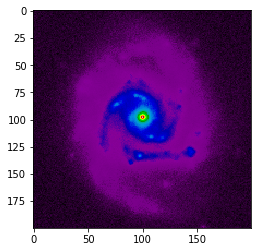

In [2]:
ban1 = fits.open("auxiliares/ban_1.fits")
ban2 = fits.open("auxiliares/ban_2.fits")

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
#fig.suptitle('fotos en dos filtros diferentes')
#ax1.imshow(ban1[0].data, cmap='nipy_spectral')
plt.imshow(ban2[0].data, cmap='nipy_spectral')

# <span style = 'color:blue'> ---------------------------------------- RUIDO ----------------------------------------
    
### *_En el primer caso es conveniente sacar la distribución de ruido con las 4 esquinas, verificar que la función gaussiana modela perfectamente el comportamiento del ruido (obtener el $\chi^2$ para lo que sigue). Posteriormente explorar la distribución de Poisson, compararar con datos. Luego generar datos aleatorios que sigan el mismo comportamiento del ruido para comparar distribuciones._*


In [3]:
datos = ban2[0].data # Usando los datos con mejor resolución.

In [4]:
def Muestra(image,xmin, xmax, ymin, ymax): # Toma un recuadro de la imágen
    muestra = image[ymin:ymax,xmin:xmax]
    return muestra

In [5]:
''' Se sacan muestras de las cuatro esquinas de la imágen donde hay información del ruido de fondo.'''
corte_noise1 = Muestra(datos, 0,25, 0,25)
corte_noise2 = Muestra(datos, 0,25, 175,200)
corte_noise3 = Muestra(datos, 175,200, 0,25)
corte_noise4 = Muestra(datos, 175,200, 175,200)
corte_noise  = np.concatenate((corte_noise1, corte_noise2, corte_noise3, corte_noise4)) 

In [6]:
def histogram(image): # Calcula la media y la desviación estandar de los datos, ademñas de graficar.
    h = np.histogram(image,normed=True)
    y = h[0]
    x = (h[1][1:] + h[1][:-1])/2
    mu = np.mean(corte_noise[:])
    sigma = np.std(corte_noise[:])
    return x,y,mu,sigma

In [7]:
'''Se aplica la función histograma a los datos de las cuatro esquinas y se extraen los valores (x,y).'''
h = histogram(corte_noise)
data_noise = h[1]
xx =[-6.6702633 , -5.1156874 , -3.5611117 , -2.006536  , -0.45196044,
        1.1026152 ,  2.6571908 ,  4.2117662 ,  5.766342  ,  7.320918]
print("mu =", h[2], ", sigma = ", h[3], ", Amplitud =", max(h[1]))

mu = 0.5168628 , sigma =  2.3390732 , Amplitud = 0.16570438304792384


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


### _*A partir de las cuatro esquinas se puede obtener una medida confiable de la distribución de ruido en los datos. En este caso los resultados fueron:*_

$\mu = 0.5168628,\:\:\:$ $\sigma = 2.3390732,\:\:\:$ $A = 0.16570438304792384$.

### _*Ahora es conveniente plantear un modelo gaussiano para observar si el comportamiento de los datos tiende a dicha distribución.*_

In [8]:
def make_gaussian(tpl,x): # Función que realiza una gaussiana a partir de mu, sigma y A.
    mu = tpl[0]
    sigma = tpl[1]
    A = tpl[2]
    gauss = A*np.exp(-((x-mu)**2)/2/sigma**2)
    return gauss

In [9]:
def ErrorFunc(tpl,x,y):
    gauss = make_gaussian(tpl,x)
    chi = np.ravel(y-gauss)
    return chi

In [10]:
tpl = [3.5,0.3,1]
x = np.arange(0,10,1) #(h[1][1:] + h[1][:-1])/2
best_params2,success = leastsq(ErrorFunc, tpl, args = (xx,data_noise))
best_params2

array([0.51827461, 2.38226722, 0.16747146])

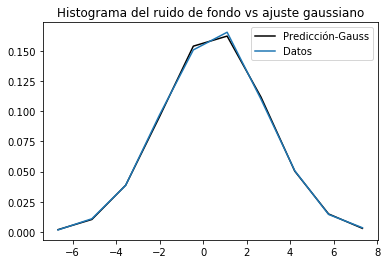

In [11]:
prueba = make_gaussian(best_params2, xx)
plt.title("Histograma del ruido de fondo vs ajuste gaussiano")
plt.plot(xx,prueba, "k", label='Predicción-Gauss')
plt.plot(xx,data_noise, label='Datos')
plt.legend()

In [12]:
chii = ErrorFunc(best_params2, x, data_noise)**2
chi = chii.sum()
chi

0.09918586786042628

### _*A partir de la función gaussiana y optimizando los parámetros que la definen, los valores para los mismos parámetros presentados anteriormente para los datos son:*_

$\mu = 0.51827461,\:\:\:$ $\sigma = 2.38226722,\:\:\:$ $A = 0.16747146$.

### _*y un $\chi^2 = 0.0099185$. Para determinar mejor el error relativo a la hora de usar la función gaussiana, podemos reproducir nuevamente datos aleatorios y optimizar la función gaussiana.*_

In [13]:
n = 1000 # Entre más datos sean, mejor será la distribución.
ys = np.random.normal(loc=0.5168628,scale=2.3390732,size=n) # Se genera la distribución de datos.
h2 = np.histogram(ys,normed=False,bins=10) # Se hace el histograma de los datos.
xg = (h2[1][1:] + h2[1][:-1])/2
tp = [10,4,10]
#yg = make_gaussian(tp,xg)
best_params1,success = leastsq(ErrorFunc, tp, args = (xg,h2[0]))
print("mu =", best_params1[0], ", sigma=", best_params1[1])
print()

print("el error relativo para mu es", (np.abs(best_params1[0]-0.5168628)/0.5168628))
print()
print("el error relativo para sigma es", (np.abs(np.abs(best_params1[1])-2.3390732)/2.3390732))
print()

chii1 = ErrorFunc(best_params1, xg, h[0])**2
chi1 = chii.sum()
chi1

mu = 0.5144426197928509 , sigma= -2.3842646934965246

el error relativo para mu es 0.004682442240279374

el error relativo para sigma es 0.019320256200842503



//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


0.09918586786042628

### _*A partir del bloque anterior de código se pueden generar una gran cantidad de histogramas y obtener sus respectivos parámetros optimizados. Esto con el fin de determinar la precisión de la función gaussiana para modelar el histograma de los datos.*_

|Nº | $ \mu_{exp}$ | $Error_r$       | $ \sigma_{exp} $| $Error_r$      |
|---|--------------|-----------------|-----------------|----------------|
| 1 |   $0.521$    |     $0.008$     |      $2.406$    |    $0.028$     |     
| 2 |   $0.474$    |     $0.081$     |      $2.273$    |    $0.028$     |  
| 3 |   $0.559$    |     $0.082$     |      $2.372$    |    $0.014$     |  
| 4 |   $0.503$    |     $0.027$     |      $2.284$    |    $0.023$     |
| 5 |   $0.519$    |     $0.006$     |      $2.472$    |    $0.057$     |
| 6 |   $0.429$    |     $0.169$     |      $2.244$    |    $0.041$     |
| 7 |   $0.525$    |     $0.015$     |      $2.178$    |    $0.069$     |
| 8 |   $0.391$    |     $0.243$     |      $2.383$    |    $0.019$     |
| 9 |   $0.574$    |     $0.110$     |      $2.247$    |    $0.039$     |
|10 |   $0.461$    |     $0.108$     |      $2.411$    |    $0.031$     |


### _*En promedio, el parámetro $\mu$ obtenido mediante la distribución gaussiana tiene un error relativo de $0.0849$ con respecto al parámetro $\mu$ de los datos (considerado como $\mu_{teo}$). Por otra parte, el promedio del error relativo del parámetro $\sigma$ es de $0.039$*_

### _*También se puede apreciar que el $\chi^2$ se mantiene intacto, sin importar las propiedades de los datos que se estén tratando.*_

### <span style = 'color:green'> Función de distribución de Poisson.

### _*Existe la posibilidad de modelar mejor la distribución de los datos. Para ello hay que definir una nueva función de distribución, la distribución de Poisson:*_

$f(k,\lambda) = \dfrac{e^{-\lambda}\lambda^k}{k!},$

### _*en donde $k$ es el número de ocurrencias del evento o fenómeno y $\lambda$ es un parámetro positivo que representa el número de veces que se espera que ocurra el fenómeno durante un intervalo dado.*_

In [14]:
def make_poisson(tpl,x): # Función que realiza una gaussiana a partir de lambda.
    poisson = []
    lambd = tpl[0]
    for k in x:
        poisson.append((np.exp(-lambd)*lambd**(k))/scipy.special.factorial(k))
    return poisson

### _*Es importante reconocer que en la distribución de Poisson, el parámetro $k$ se asocia con la variable $x$ de la distribución gaussiana. Es decir, la función de distribución de Poisson se graficará vs el parámetro $k$, y la variable a optimizar sería $\lambda$. También es necesario recalcar que $k$ es una variable que solo adquiere valores enteros [(para conocer más sobre la distribución de Poisson puede hacer click aquí)](https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459).*_

In [15]:
def ErrorPoisson(tpl,x,y):
    poiss = make_poisson(tpl,x)
    chi = np.ravel(y-poiss)
    return chi

In [16]:
par = [20]
xp = np.arange(0, 10, 1)
best_params3,success = leastsq(ErrorPoisson, par, args = (xp, data_noise))
best_params3
prueba2 = make_poisson(best_params3, xp)

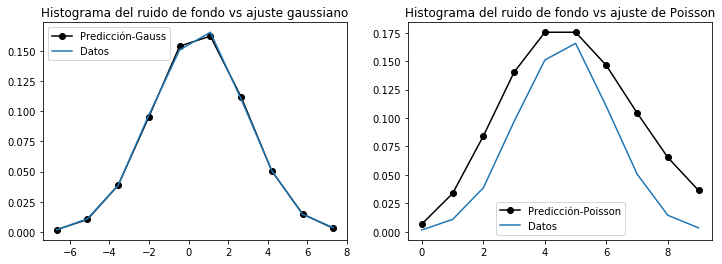

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

plt.subplot(1, 2, 2)
plt.title("Histograma del ruido de fondo vs ajuste de Poisson")
plt.plot(xp,prueba2, "o-k", label='Predicción-Poisson')
plt.plot(xp,data_noise, label='Datos')
plt.legend()

plt.subplot(1, 2, 1)
plt.title("Histograma del ruido de fondo vs ajuste gaussiano")
plt.plot(xx,prueba, "o-k", label='Predicción-Gauss')
plt.plot(xx,data_noise, label='Datos')
plt.legend()

### _*Es evidente que la función de distribución de Poisson no tuvo los resultados esperados. Esto puede deberse a que solo se cuenta con el parámetro $\lambda$ para ser optimizado. Además la variable $k$ solo puede tomar valores enteros positivos, lo que implica cambiar la malla del eje horizontal, perdiendo información importante como la posición real del valor de cada uno de los datos.*_

# <span style = 'color:blue'> ------------------------------- AJUSTE DEL MODELO -------------------------------
    


### _*Primero hay que definir las funciones fundamentales para esta parte del modelo: la función que modela la exponencial, la función de error y la que optimiza la función exponencial.*_

In [18]:
def Model_Exponential(param, image):
    """
    Función que crea el modelo exponencial de la galaxia en cualquiera de las dos longitudes de onda
    """
    
    exponential = np.zeros(image.size)

    x0  = param[0]
    y0  = param[1]
    amp = param[2]
    r0  = param[3]
    phi = np.deg2rad(param[4])
    
    x  = np.arange(image.shape[0])
    y  = np.arange(image.shape[1])
    xx, yy = np.meshgrid(x,y)
    #-----------------------------------------------------------
    r   = np.sqrt( ( (xx- x0)/np.cos(phi)  )**2 + (yy - y0)**2 )
    exponential = amp*np.exp(-r/r0)
    
    return exponential, r

In [19]:
def Error_Func(param, image):
    """
    Función que calcula el error del modelo planteado
    """
    exponential, r = Model_Exponential(param, image)
    chi            = np.ravel(image - exponential)
    return chi

In [20]:
def Func_Model(image, amp, r0, phi):
    """
    Función que ajuste el modelo de cualquiera de las dos longitudes de onda por mínimos cuadrados
    """
    x0 = image.shape[0]/2
    y0 = image.shape[1]/2
    
    param = [x0, y0, amp, r0, phi]
    best_params1, success = leastsq(Error_Func, param, args= (image))
    phi = best_params1[4]
    L_model, r = Model_Exponential(best_params1, image)
    
    return L_model, r, best_params1

In [21]:
phi0 = 60
model, r, params = Func_Model(datos, 500 , 3, phi0)
print(params)
x0  = params[0]
y0  = params[1]
amp = params[2]
r0  = params[3]
phi = params[4]

[ 99.7256284   97.86622252 224.27610656  24.38663101  16.38138824]


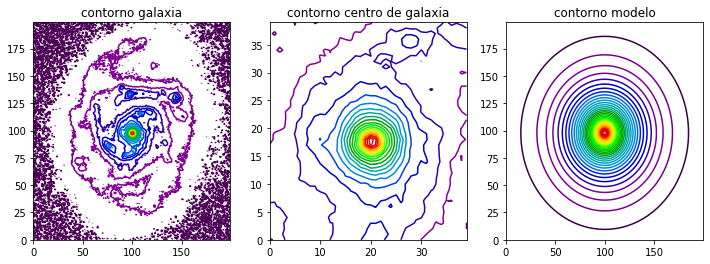

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (12,4))

plt.subplot(1, 3, 1)
plt.title("contorno galaxia")
plt.contour(datos, 30, cmap = "nipy_spectral")

plt.subplot(1, 3, 2)
plt.title("contorno centro de galaxia")
plt.contour(datos[80:120,80:120], 20, cmap = "nipy_spectral")


plt.subplot(1, 3, 3)
plt.title("contorno modelo")
plt.contour(model, 40, cmap = "nipy_spectral")

### _*A mi parecer el modelo exponencial es realmente apropiado para estudiar la zona central de la galaxia como se apredcia en los mapas de contorno expuestos previamente. Sin embargo, en las galaxias en espiral se tienden a deformar los contornos de "iso-intensidad", haciendo que el modelo pierda exactitud.*_

### _*Posteriormente para realizar un mejor análisis de la galaxia, se elimina el ruido de fondo.*_

0.5168628 2.3390732 14.551301896572113


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


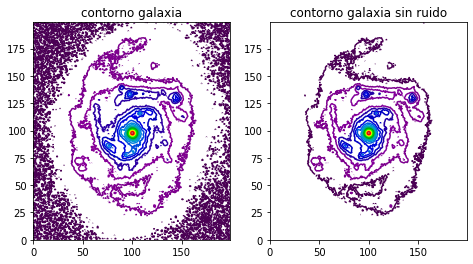

In [23]:
x,y,mu,sigma = histogram(datos)
sky = mu+6*sigma
datos_m = datos.copy()
mask = (datos_m < sky)
datos_m[mask] = np.nan 

print(mu,sigma,sky)

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,4))

plt.subplot(1, 3, 1)
plt.title("contorno galaxia")
plt.contour(datos, 30, cmap = "nipy_spectral")

plt.subplot(1, 3, 2)
plt.title("contorno galaxia sin ruido")
plt.contour(datos_m, 30, cmap = "nipy_spectral")


In [24]:
chi_noise = (Error_Func(params, datos)**2).sum()
chi_noise

5242623.378886939

### _*Aunque la imagen del contorno sin ruido se ve limpia y muy prometedora para optimizar los parámetros basados en estos datos, el comportamiento del parámetro $\chi^2$ es sorpresivamente diferente al que se espera.*_

### <span style = 'color:green'> Elección del valor promedio del ruido de fondo.



In [25]:
chis =[]
skys = np.arange(0, sky, 0.5)
datos_s = datos.copy()#np.zeros(datos.shape)
for l in skys:
    for i in np.arange(datos.shape[0]):
        for j in np.arange(datos.shape[1]):
            if datos[i,j] <= l:
                datos_s[i,j] = 0
    model2, r, param2 = Func_Model(datos_s, 500 , 3, phi0)
    chi_clean = (Error_Func(params, datos_s)**2).sum()
    chis.append(chi_clean)


Text(0.5, 1.0, 'Error de chi cuadrado en función del recorte del cielo')

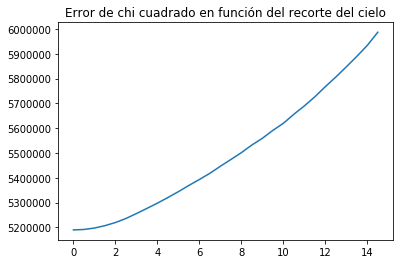

In [26]:
plt.plot(skys, chis)
plt.title("Error de chi cuadrado en función del recorte del cielo")

### _*Si se permiten mayores valores para el parámetro asociado al ruido de fondo, la gráfica del $\chi^2$ sigue creciendo, lo que en pocas palabras significa que el eliminar el ruido de fondo aumenta el error del $\chi^2$. Esto puede deberse a que el truncamiento brusco de los datos no es compatible con la caida suave de la función exponencial. Es por esto que el uso de una convolución podría suavizar los datos, y a su vez, disminuir el valor de $\chi^2$.*_ 

In [27]:
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans

In [28]:
kernel = Gaussian2DKernel(x_stddev=20) #Aquí se plantea la función con la que se hará la convolución

dat_smooth = interpolate_replace_nans(datos_m, kernel)

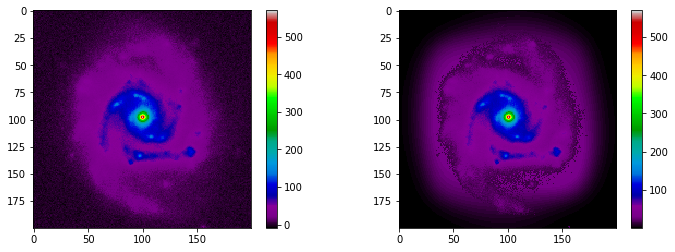

In [29]:

fig, (ax2, a2x) = plt.subplots(1,2, figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(datos, cmap="nipy_spectral")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(dat_smooth, cmap="nipy_spectral")
plt.colorbar()

In [30]:
chis =[]
skys = np.arange(0, sky/3, 0.3)
datos_s = datos.copy()#np.zeros(datos.shape)
for l in skys:
    for i in np.arange(datos.shape[0]):
        for j in np.arange(datos.shape[1]):
            if datos[i,j] <= l:
                datos_s[i,j] = 0
    model2, r, param2 = Func_Model(datos_s, 500 , 3, phi0)
    smooth = interpolate_replace_nans(model2, kernel)
    chi_clean = (Error_Func(params, smooth)**2).sum()
    chis.append(chi_clean)

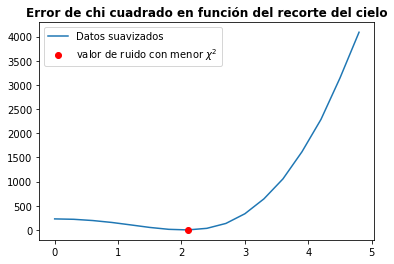

In [31]:
plt.plot(skys, chis, label = "Datos suavizados")
plt.plot([2.1],[0.7115],'ro', label = "valor de ruido con menor $\chi^2$")
plt.title("Error de chi cuadrado en función del recorte del cielo", fontweight="bold")
plt.legend()

### _*Lo anterior implica que el suavizado cumplió su función. Sin embargo, el $\chi^2$ vuelve a aumentar, probablemente porque el suavizado no es suficiente para contrarrestar la eliminación de ruido.*_

### _*Basado en el análisis anterior, el valor para el ruido de fondo más apropiado es $2.1 \approx \mu + \frac{2}{3}\sigma$*_

In [32]:
datos_b = datos.copy()#np.zeros(datos.shape)

for i in np.arange(datos.shape[0]):
        for j in np.arange(datos.shape[1]):
            if datos[i,j] <= 2.1:
                datos_b[i,j] = 0
model3, r, param3 = Func_Model(datos_b, 500 , 3, phi0)
smooth3 = interpolate_replace_nans(model3, kernel)

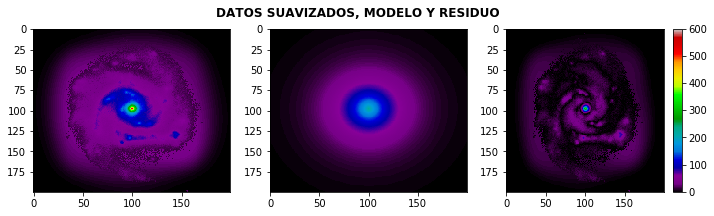

In [214]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle('DATOS SUAVIZADOS, MODELO Y RESIDUO', fontweight = "bold")

plt.subplot(1, 3, 1)
plt.imshow(dat_smooth, vmin=0, vmax=600, cmap='nipy_spectral', aspect='auto')
plt.subplot(1, 3, 2)
plt.imshow(smooth3, vmin=0, vmax=600, cmap='nipy_spectral', aspect='auto')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(dat_smooth - smooth3), vmin=0, vmax=600, cmap='nipy_spectral', aspect='auto')
plt.colorbar()


### _*El perfil de intensidad unidimensional para los datos filtrados se observa en la siguiente gráfica.*_

In [34]:
ere = np.arange(0,120,5)
expo = amp*np.exp(-ere/r0)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


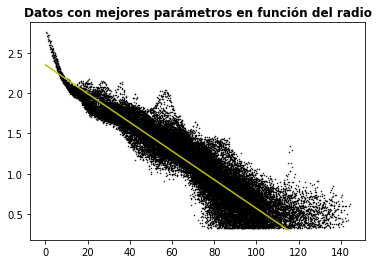

In [210]:
plt.plot(r[:],np.log10(datos_b[:]),".k",markersize=1)
plt.plot(ere,np.log10(expo),"-y",markersize=1)
plt.title("Datos con mejores parámetros en función del radio", fontweight = "bold")
plt.show()

# <span style = 'color:blue'> ----------------  VALIDACIÓN DE LA METODOLOGIA DE AJUSTE ----------------

### _*Generar galaxias y ruidos a partir de los datos, que sean consistentes; y generar la incertidumbre de la función del modelo.*_

In [36]:
paras0 = [90, 80, 100, 20, 40] # x0, y0, amp, r, phi
data_made1, rr = Model_Exponential(paras0, datos)
data_made = data_made1 + np.random.normal(loc=mu,scale=sigma,size=data_made1.shape)

In [37]:
fake_model, r2, paras = Func_Model(data_made, 500 , 3, phi0)
print(paras)

Er = []
for i in np.arange(0,len(paras0),1):
    Er.append(np.abs(paras0[i] - paras[i])/np.abs(paras0[i]))
    
print(Er)

[  90.02599304   79.98084888   98.09553691   20.80110118 -139.98225089]
[0.00028881153244084444, 0.000239389029653303, 0.01904463093592497, 0.04005505895428581, 4.499556272223014]


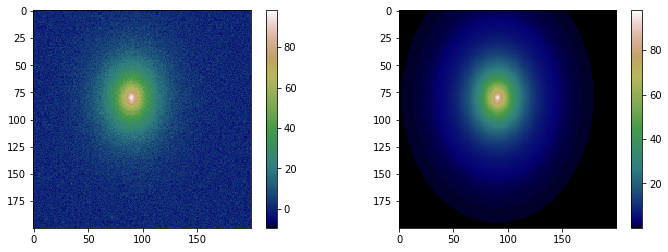

In [38]:
fig, (ax1, axs2) = plt.subplots(1,2, figsize = (12,4))

plt.subplot(1,2,1)
plt.imshow((data_made), cmap = "gist_earth")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow((fake_model),cmap = "gist_earth")
plt.colorbar()

### _*Al repetir el proceso reiteradamente de forma aleatoria, se pueden obtener una estimación de la efectividad del modelo. En este caso los valores teóricos son aquellos que se inponen en "data_made" y los valores experimentales son los obtenidos al realizar la optimización con "fake_model".*_

|Nº|$x0_{teo}$|$x0_{exp}$|$y0_{teo}$|$y0_{exp}$|$A_{teo}$|$A_{exp}$|$r_{teo}$|$r_{exp}$|$\phi_{teo}$|$\phi_{ex}$|
|--|---       |---       |---       |---       |---      |   ---   |---      |---      |---         |---        |
|1 | 90       | 89.997   |  80      | 79.946   | 100     |  98.257 |      20 |  20.752 | 40         | 40.197    |
|2 | 20       |  19.951  |  30      | 29.965   | 300     |299.207  | 40      |   40.4  |  10        | 9.983     |
|3 |  120     | 119.996  | 100      |  99.992  |  500    | 500.0760|  70     | 70.20   |  45        | 44.980    |
| 4| 10       | 10.020   |  150     |  149.919 | 50      | 48.672  |  15     |  16.116 |  75        |  76.843   |
| 5| 145      |  144.999 |  15      |  14.998  | 175     | 174.491 | 90      |90.952   |    83      | 82.962    |


### _*Con los datos anteriores se obtienen los errores relativos para cada uno de los datos impuestos a mano. Al promediar estos errores relativos, proporcionan una medida de la precisión de la optimización para cada uno de los parámetros.*_


|Nº| $E_r(x_0)$          | $E_r(y_0)$         | $E_r(A)$           | $E_r(r)$           | $E_r(\phi)$  |
|--|---|---|---|---|---|
| 1|$3.952\times 10^{-4}$|$5.174\times10^{-4}$|$2.041\times10^{-2}$|$3.952\times10^{-4}$|$4.505\times 10^{-3}$|
| 2|$2.437\times 10^{-3}$|$1.170\times10^{-3}$|$2.643\times10^{-3}$|$1.000\times10^{-2}$|$1.998\times 10^{-2}$ |
| 3|$2.579\times 10^{-5}$|$7.910\times10^{-5}$|$1.521\times10^{-4}$|$2.924\times10^{-3}$|$1.999\times 10^{-2}$ |
| 4|$2.041\times 10^{-3}$|$5.335\times10^{-4}$|$2.654\times10^{-2}$|$7.443\times10^{-2}$|$2.797\times 10^{-2}$|
| 5|$4.441\times 10^{-6}$|$1.276\times10^{-4}$|$2.906\times10^{-3}$|$1.058\times10^{-2}$|$1.999\times 10^{-3}$ |

#### _*Para el parámetro $x_0$,  $9.801 \times 10^{-4}$*_

#### _*Para el parámetro $y_0$, $4.855 \times 10^{-4}$*_ 

#### _*Para el parámetro $A$, $1.053 \times 10^{-2}$*_

#### _*Para el parámetro $r$, $1.966 \times 10^{-2}$*_

#### _*Para el parámetro $\phi$, $1.488 \times 10^{-2}$*_

### _*Si bien el modelo es bastante eficaz para todos los parámetros, presenta una efectividad mucho mayor en $x_0$ y $y_0$. Esto puede ser debido a que tales parámetros especifican el punto de mayor luminosidad, y dicho punto al ser el más brillante, no se ve tan afectado por el ruido de fondo.*_


# <span style = 'color:blue'> ---------- EXPLORACIÓN DE INCERTIDUMBRE EN LOS RESULTADOS ----------

### _*Realizar lo que la función de scipy hace al optimizar los parámetros, pero ahora a mano y con rangos limitados que reduzcan el tiempo computacional debido a la cantidad de bucles. Luego salvo el xhi-cuadrado para cada set de parámetros y grafico. Son 5 parámetros, para la exploración de a dos parámetros debo crear modelos que solo optimicen los otros tres parámetros y esos se dejan fijos, la incertidumbre podría ser a ojimetro.*_


### <span style = 'color:green'> Cálculo de $\chi^2$ para $x_0$ y $y_0$.

In [69]:
x  = np.arange(datos.shape[0])
y  = np.arange(datos.shape[1])
xx, yy = np.meshgrid(x,y)
#-----------------------------------------------------------

rang1 = np.arange(95, 105, 0.5)
rang2 = np.arange(95, 105, 0.5)
xhi_mat = np.zeros((rang1.shape[0], rang2.shape[0]))
l = 0
m = 0 
for i in rang1:
    l = l + 1
    for j in rang2:
        m = m + 1
        r   = np.sqrt( ( (xx- i)/np.cos(phi)  )**2 + (yy - j)**2 )
        exponential = amp*np.exp(-r/r0)
        xhi = np.ravel(datos - exponential)
        xhi2 = (xhi**2).sum()
        xhi_mat[l-1,m-1] = xhi2
    m = 0

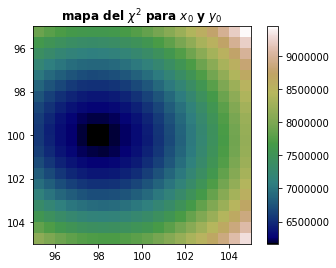

In [70]:
plt.imshow(xhi_mat, cmap = "gist_earth", extent=[95,105,105,95])
plt.title("mapa del $\chi^2$ para $x_0$ y $y_0$", fontweight = "bold")
plt.colorbar()

### _*Se puede observar que el punto de mejor $\chi^2$ concuerda con el obtenido a partir de la optimización, pero esta imagen permite observar además el rango de puntos vecinos que poseen también un buen valor de $\chi^2$.*_

### <span style = 'color:green'> Cálculo de $\chi^2$ para $A$ y $r_0$.

In [110]:
x  = np.arange(datos.shape[0])
y  = np.arange(datos.shape[1])
xx, yy = np.meshgrid(x,y)
#-----------------------------------------------------------

rang1 = np.arange(190, 260, 1)
rang2 = np.arange(10, 40, 1)
xhi_mat = np.zeros((rang1.shape[0], rang2.shape[0]))
l = 0
m = 0 
for i in rang1:
    l = l + 1
    for j in rang2:
        m = m + 1
        r   = np.sqrt( ( (xx- x0)/np.cos(phi)  )**2 + (yy - y0)**2 )
        exponential = i*np.exp(-r/j)
        xhi = np.ravel(datos - exponential)
        xhi2 = (xhi**2).sum()
        xhi_mat[l-1,m-1] = xhi2
    m = 0

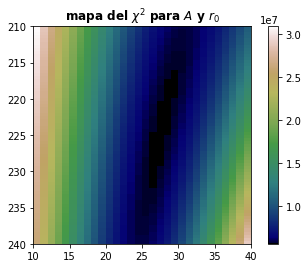

In [111]:
plt.imshow(xhi_mat, cmap = "gist_earth", extent=[10,40,240,210])
plt.title("mapa del $\chi^2$ para $A$ y $r_0$", fontweight = "bold")
plt.colorbar()

### _*Este caso es interesante porque existe un amplio rango de valores para $A$ y $r_0$ para optimizar el error. Aún así, la región concuerda con el valor presentado al optimizar los parámetros mediante la función leastsq.*_

### <span style = 'color:green'> Cálculo de $\chi^2$ para $r_0$ y $\phi_0$.

In [96]:
x  = np.arange(datos.shape[0])
y  = np.arange(datos.shape[1])
xx, yy = np.meshgrid(x,y)
#-----------------------------------------------------------

rang1 = np.arange(20, 30, 0.5)
rang2 = np.arange(0, 30, 1)
xhi_mat = np.zeros((rang1.shape[0], rang2.shape[0]))
l = 0
m = 0 
for i in rang1:
    l = l + 1
    for j in rang2:
        m = m + 1
        r   = np.sqrt( ( (xx- x0)/np.cos(np.deg2rad(j))  )**2 + (yy - y0)**2 )
        exponential = amp*np.exp(-r/i)
        xhi = np.ravel(datos - exponential)
        xhi2 = (xhi**2).sum()
        xhi_mat[l-1,m-1] = xhi2
    m = 0

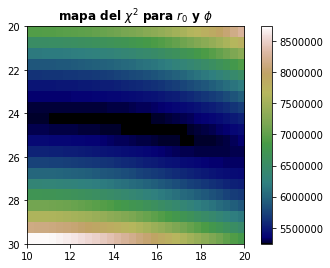

In [98]:
plt.imshow(xhi_mat, cmap = "gist_earth", extent=[10,20,30,20])
plt.title("mapa del $\chi^2$ para $r_0$ y $\phi$", fontweight = "bold")
plt.colorbar()

### _*Este caso es similar al anterior, en el cual los valores optimos para los parámetros son varios, con un $\chi^2$ muy similar.*_